In [1]:
import tensorflow as tf
import scipy.linalg as la
from core.TensorflowState import TensorflowState
from system.SystemParametersGeneral import SystemParametersGeneral
from math_functions.c_to_r_mat import CtoRMat
from runtime_functions.ConvergenceGeneral import ConvergenceGeneral
from runtime_functions.run_session import run_session

%pylab inline
import random as rd
import time
from IPython import display

Populating the interactive namespace from numpy and matplotlib


In [2]:
'''
qubit_pi
two_modes_cnot
'''

simulation_system = "qubit_pi"

In [3]:
if simulation_system == "qubit_pi":
    class SystemParameters(SystemParametersGeneral):
        
        def __init__(self):
            total_time = 5.0
            SystemParametersGeneral.__init__(self,total_time)
            self.init_states()
            
        def init_states(self):
            # concerned states
            self.states_concerned_list = [0,self.mode_state_num**2]
            self.init_vectors()
            
            # Initialize initial and target states in numpy vector
            Ut_c = la.expm((0-1j)*self.total_time*self.H0_c)
            Ct_c = Ut_c.copy()

            Ct_c[self.mode_state_num**2,0] = 1
            Ct_c[0,self.mode_state_num**2] = 1
            Ct_c[0,0] = 0
            Ct_c[self.mode_state_num**2,self.mode_state_num**2] = 0

            self.initial_state = self.identity
            self.target_state = CtoRMat(Ct_c)

In [4]:
if simulation_system == "two_modes_cnot":
    class SystemParameters(SystemParametersGeneral):
        
        def __init__(self):
            total_time = 30
            SystemParametersGeneral.__init__(self,total_time)
            self.init_states()
            
        def init_states(self):
            # concerned states
            self.states_concerned_list = [0,1,self.mode_state_num,self.mode_state_num+1] #g00,g01,g10,g11
            self.init_vectors()
            
            # Initialize initial and target states in numpy vector           
            Ut_c = la.expm((0-1j)*self.total_time*self.H0_c)
            Ct_c = Ut_c.copy()
            
            Ct_c[self.mode_state_num+1,self.mode_state_num] = 1
            Ct_c[self.mode_state_num,self.mode_state_num+1] = 1
            Ct_c[self.mode_state_num,self.mode_state_num] = 0
            Ct_c[self.mode_state_num+1,self.mode_state_num+1] = 0
            
            self.initial_state = self.identity
            self.target_state = CtoRMat(Ct_c)
            

In [5]:
sys_para = SystemParameters()

In [6]:
with tf.device('/gpu:0'):
    tfs = TensorflowState(sys_para)
    graph = tfs.build_graph()

Building graph:
State initialized.
Operators initialized.
Operators weight initialized.
Intermediate states initialized.
Propagator initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!


In [7]:
class Convergence(ConvergenceGeneral):

        
    def __init__(self):
        # paramters
        self.sys_para = SystemParameters()
        self.rate = 0.01
        self.update_step = 100
        self.conv_target = 1e-8
        self.max_iterations = 5000
        
        self.learning_rate_decay = self.max_iterations/2
        
        self.reg_alpha_coeff = 0.01
        
        self.z_reg_alpha_coeff = 0.01
        
        self.dwdt_reg_alpha_coeff = 0.0001
        self.d2wdt2_reg_alpha_coeff = 0.001*0.0001
        
        self.inter_reg_alpha_coeff = 100.0
        
        self.reset_convergence()
conv = Convergence()

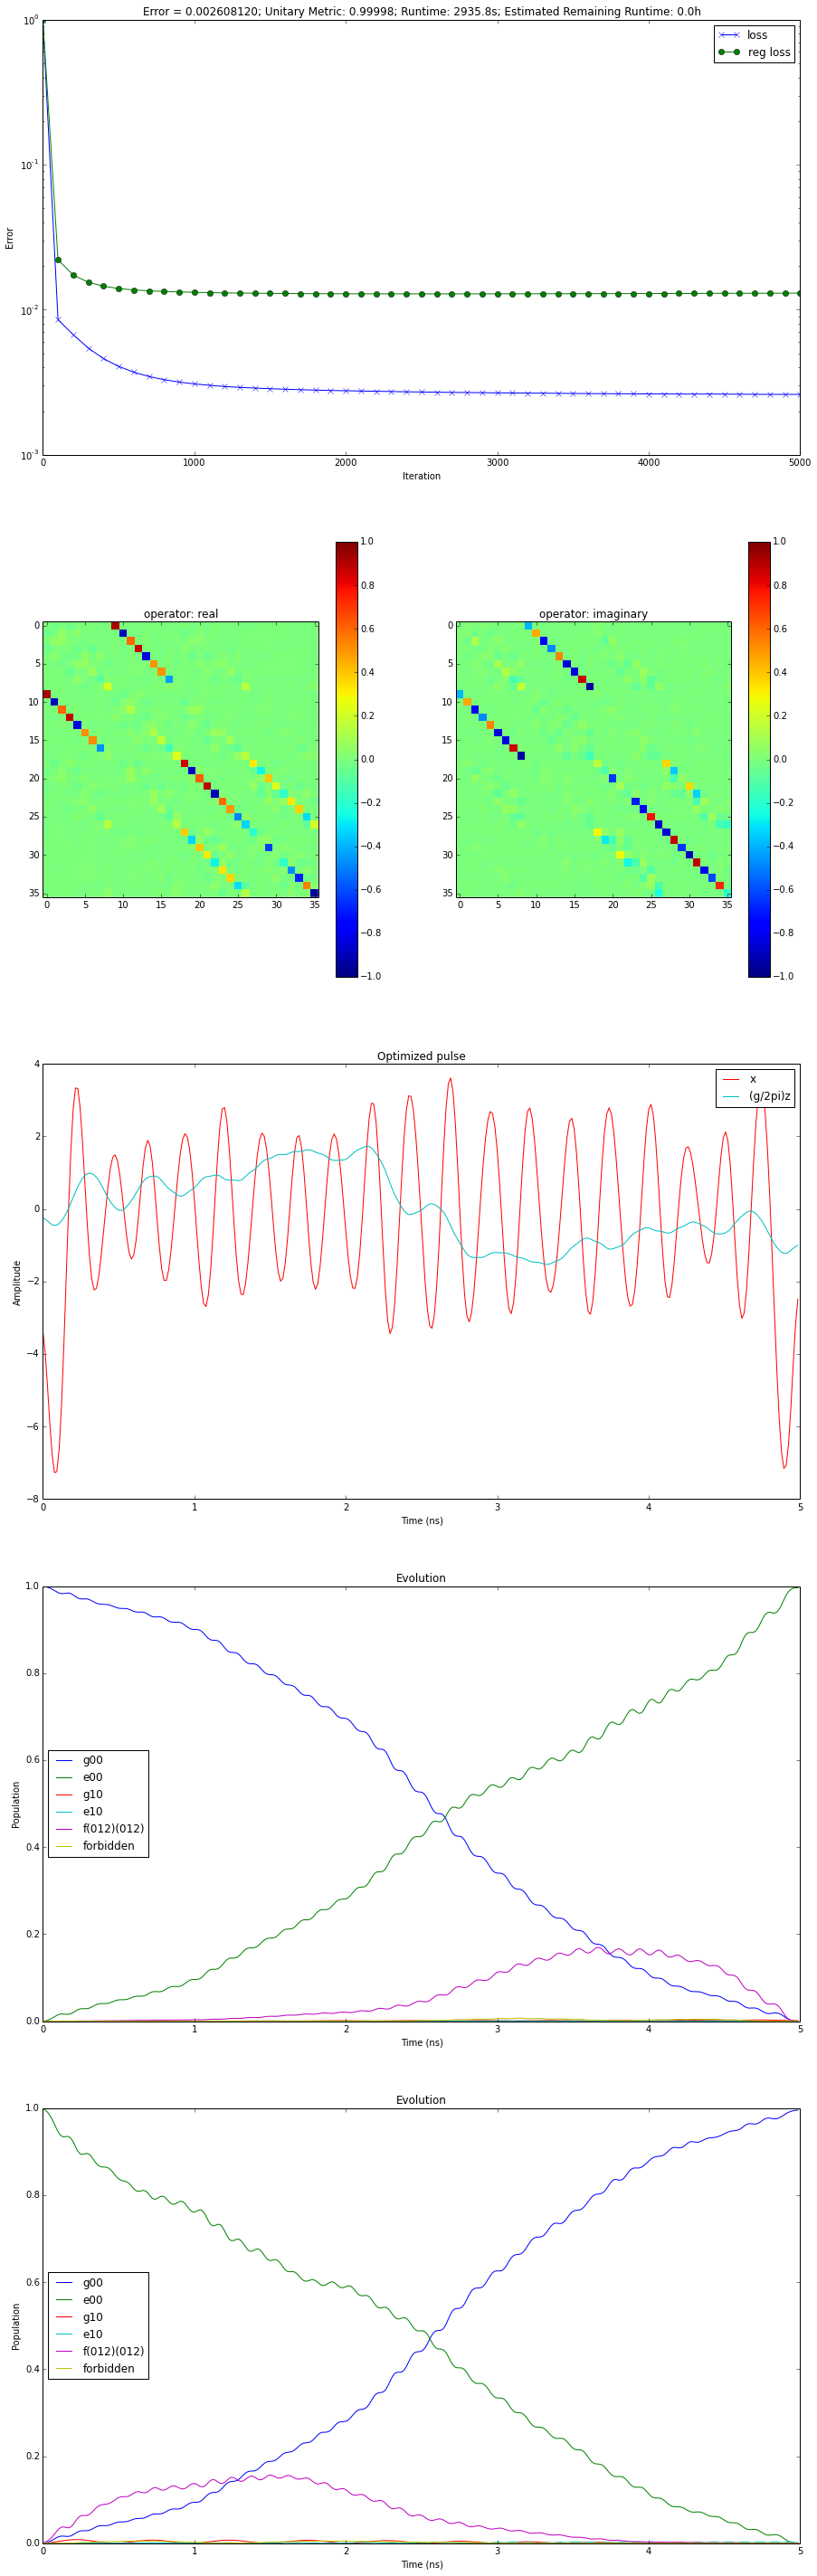

In [8]:
try:
    run_session(tfs,graph,conv,sys_para)
except KeyboardInterrupt:
    display.clear_output()